In [1]:
number_iteration=10000
J1=0.5
J2=J1;

In [2]:
# Quantum mechanics
from qutip import *
# Core libraries
import numpy as np
import pandas as pd
import random
import random as ra
# Machine learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
# Machine learning - Scikit-learn
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor
)
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
# Other ML libraries
import xgboost as xgb
from catboost import CatBoostRegressor 
# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
# Utilities
from collections import OrderedDict

In [3]:
def Negativity(ρ):
    return round(abs(negativity(ρ,0)),7)
def Positioned_α(Dim_1,Dim_2):
    n=[0, 1, 0.5, 0.5]
    λ = [random.choice(n) for i in range(Dim_1*Dim_2)]
    μ=0; σ=1; a=0; b=1; G=1; U=0; 
    α=[G*(λ[i]*np.random.normal(μ,σ)+(1-λ[i])*1j*np.random.normal(μ,σ))+U*(λ[i]*ra.uniform(a,b)+(1-λ[i])*1j*ra.uniform(a,b)) for i in range(Dim_1*Dim_2)]
    return α

def Positioned_state(α,Basis,index,number_iteration):
    N=len(Basis)
    values = [0] * N
    # Randomly choose two unique positions
    R=(index/number_iteration)*N  
    positions = random.sample(range(N), round(R+0.5))
    
    for pos in positions:
        values[pos] = 1
    S=sum([values[i]*α[i]*Basis[i] for i in range(N)])
    return S#.unit()

In [4]:
#############################################################################################################################

In [5]:

                            #This code is for generating random states and evaluating their (Entanglemnt)
#Concurrence and expectation  values for the states as  features
def create_states(J1,J2,number_iteration):
    Features={}
    Dim_1=int(2*J1+1); Dim_2=int(2*J2+1); 
    number_features=Dim_1*Dim_2
    #Features['J1']=[]; Features['J2']=[]; 
    for i in range(number_features):
        Features['α_'+str(i+1)+'_re']=[]
        #Features['α_'+str(i+1)+'_im']=[]
    Features['N']=[]
    R1=0.9; R2=0.05;     # R1 controls seperate and partially entanglemnt states. R2 controls partially and maximum entangled states
    for r in range(1,number_iteration):
        if r<=R1*number_iteration:
            μ=0; σ=1; a=0; b=1; G=0; U=1; R=0;        #U for uniform distribution, G for gauss distribution,  R for real parts
            α=[G*(np.random.normal(μ,σ)+R*1j*np.random.normal(μ,σ))+U*(ra.uniform(a,b)+R*1j*ra.uniform(a,b)) for i in range(Dim_1*Dim_2)]
            #α=Positioned_α(Dim_1,Dim_2)   #To mix the amplitudes to be real or pure imaginary or mix
            Basis=[tensor(basis(Dim_1,i),basis(Dim_2,j)) for i in range(Dim_1) for j in range(Dim_2)]
            ψ=Positioned_state(α,Basis,r,number_iteration).unit()
            #ψ=sum([α[k]*Basis[k] for k in range(len(α))]).unit()
            #Features['J1'].append(J1); Features['J2'].append(J2); 
            for i in range(number_features):
                Features['α_'+str(i+1)+'_re'].append(((Basis[i]*ψ.dag()).tr()).real)
                #Features['α_'+str(i+1)+'_im'].append(((Basis[i]*ψ.dag()).tr()).imag)
            Features['N'].append(Negativity(ket2dm(ψ))/max(J1,J2))
            
        elif r>R1*number_iteration and r<=(R1+R2)*number_iteration: 
            Basis=[tensor(basis(Dim_1,i),basis(Dim_2,j)) for i in range(Dim_1) for j in range(Dim_2)]
            ψ=sum([ra.uniform(0,1)*tensor(basis(Dim_1,i),basis(Dim_2,i)) for i in range(Dim_1)]).unit()
            for i in range(number_features):
                Features['α_'+str(i+1)+'_re'].append(((Basis[i]*ψ.dag()).tr()).real)
                #Features['α_'+str(i+1)+'_im'].append(((Basis[i]*ψ.dag()).tr()).imag)
            Features['N'].append(Negativity(ket2dm(ψ))/max(J1,J2))
        else:
            Basis=[tensor(basis(Dim_1,i),basis(Dim_2,j)) for i in range(Dim_1) for j in range(Dim_2)]
            s=ra.uniform(0,np.pi/2); 
            ψ=(np.cos(s)*tensor(basis(Dim_1,0),basis(Dim_2,0))+np.sin(s)*tensor(basis(Dim_1,Dim_1-1),basis(Dim_2,Dim_2-1))).unit()
            for i in range(number_features):
                Features['α_'+str(i+1)+'_re'].append(((Basis[i]*ψ.dag()).tr()).real)
                #Features['α_'+str(i+1)+'_im'].append(((Basis[i]*ψ.dag()).tr()).imag)
            Features['N'].append(Negativity(ket2dm(ψ))/max(J1,J2))
    return Features

In [6]:
All_data=pd.DataFrame(create_states(J1,J2,number_iteration))
All_data=All_data.dropna()
All_data.to_csv('Pure states training for '+str(J1)+'.csv')

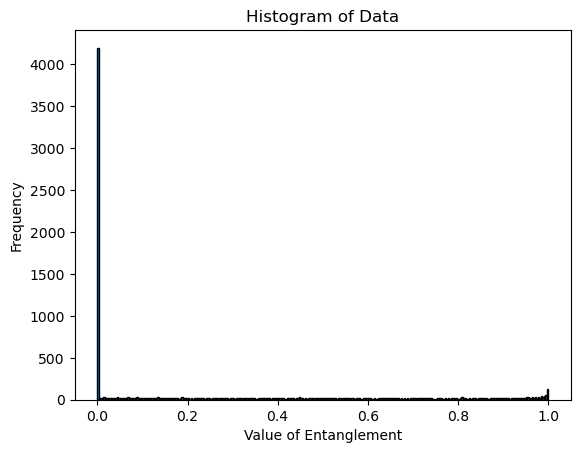

In [7]:
bins = [i/300 for i in range(0,301)]
plt.hist(All_data['N'], bins, edgecolor='black')  # 'bins' can be adjusted
plt.title('Histogram of Data')
plt.xlabel('Value of Entanglement')
plt.ylabel('Frequency')
plt.show()

In [8]:
########################################################################################################################

In [9]:

                            #This code is for generating pure states and evaluating their (Entanglemnt)

def pure_states(J1,J2,number_iteration):
    Features={}
    Dim_1=int(2*J1+1); Dim_2=int(2*J2+1); 
    number_features=Dim_1*Dim_2
    #Features['J1']=[]; Features['J2']=[]; 
    for i in range(number_features):
        Features['α_'+str(i+1)+'_re']=[]
        #Features['α_'+str(i+1)+'_im']=[]
    Features['N']=[]   #number_iteration

    zero_op = Qobj(np.zeros((Dim_1, Dim_2)))
    
    for α in np.linspace(0,np.pi/2,number_iteration):
        Basis=[tensor(basis(Dim_1,i),basis(Dim_2,j)) for i in range(Dim_1) for j in range(Dim_2)]
        ψ=(np.cos(α)*tensor(basis(Dim_1,0),basis(Dim_2,0))+np.sin(α)*tensor(basis(Dim_1,Dim_1-1),basis(Dim_2,Dim_2-1))).unit()
        ρ=ket2dm(ψ)
        
        #Features['J1'].append(J1); Features['J2'].append(J2); 
        for i in range(number_features):
            Features['α_'+str(i+1)+'_re'].append(((Basis[i]*ψ.dag()).tr()).real)
            #Features['α_'+str(i+1)+'_im'].append(((Basis[i]*ψ.dag()).tr()).imag)
        Features['N'].append(Negativity(ket2dm(ψ))/max(J1,J2))
    return Features


In [10]:
tested_data=pd.DataFrame(pure_states(J1,J2,number_iteration))
tested_data=tested_data.dropna()
tested_data.to_csv('Pure states tested for '+str(J1)+'.csv')